This notebook aims at implementing a method for face recognition described in :

Face Recognition by Sparse Representation
by 
Arvind Ganesh, Andrew Wagner, Zihan Zhou
Coordinated Science Lab, University of Illinois, Urbana, USA
Allen Y. Yang
Department of EECS, University of California, Berkeley, USA
Yi Ma and John Wright
Visual Computing Group, Microsoft Research Asia, Beijing, China

The modelisation is based on the idea that :
1. An face image $y$ is a linear combination of a database $\Phi_i$ of images from the same person
2. If we concatenate all the databases $\Phi_i$ into one $\Phi$ then $y$ has a sparse representation in respect to $\Phi$
The problem of face recognition can then be expressed as a minimization problem :
$$argmin_{c,e} ||c||_0 : y = \Phi c$$

In order to have a robust face recognition (to occlusion and corruption of the images), we introduce an error term, which also has to be sparse.
Hence the new minimization problem :
$$argmin_{c,e} ||c||_0 + ||e||_0 : y = \Phi c + e$$

Finally, inspired from the Compressed Sensing theory, we choose to perform a L1-minimization which is way more effective, yet still succesful to recover sparse solution in the right conditions.
$$argmin_{c,e} ||c||_1 + ||e||_1 : y = \Phi c + e$$

In [118]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn import linear_model as LM
from numpy import linalg as LA

In [4]:
# PRINT IMAGES

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [123]:
# LOAD, TRANSFORM AND STORE DATA

class Recognition(object):
    
    def __init__(self, data_path='orl_faces/', n_class=40, resize=None, train_size=None):
        self.data_path = data_path
        self.n_class = n_class
        self.data = self.load_faces()
        if resize is not None:
            self.resized_data = self.resize(resize)
        else:
            self.resized_data = self.data
        self.phi, self.clpos = self.build_phi(train_size)
        self.gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(self.phi), self.phi)))
        self.true_class = [j for l in [[i+1]*5 for i in range(40)] for j in l]
        
    def load_faces(self):
        data = dict()
        for i in range(1, self.n_class+1):
            images = list()
            for j in range(1, 11):
                path = self.data_path + 's' + str(i) + '/' + str(j) + '.pgm'
                images.append(cv2.imread(path, 0))
            data[i] = images
        return data
    
    def show(self, i, j, resize=False): 
        if resize:
            img = self.resized_data[i][j]
        else:
            img = self.data[i][j]
        plt.imshow(img, cmap='gray')
        plt.title(str(i) + ' - ' + str(j))
        plt.show()
        

    def resize(self, dsize):
        resized_data = dict()
        for i, l in self.data.items():
            images = list()
            for img in l:
                images.append(cv2.resize(img, dsize, interpolation=cv2.INTER_AREA))
            resized_data[i] = images
        return resized_data
    
    
    def build_phi(self, train_size=None):
        images = list()
        position = dict()
        index = 0
        for i, l in self.resized_data.items():
            if train_size is None:
                print('nb of images per class in phi : half')
                train_size = len(l)//2
            else:
                pass
            images += l[:train_size]
            position[i] = [index, index + train_size]
            index = index + train_size
        return np.transpose(np.vstack([img.flatten() for img in images])), position

    def which_class(self, c):
        """Find the most represented class in the vector c."""
        return np.argmax(np.sum(c.reshape((self.n_class, len(c)//self.n_class)), axis=1)) + 1
    
    def class_select(self, x, classe):
        """restriction of x to class 'classe' """
        rest = np.zeros(self.phi.shape[1])
        select = np.asarray(x[self.clpos[classe][0]:self.clpos[classe][1]])
        rest[self.clpos[classe][0]:self.clpos[classe][1]] = select
        return rest

In [46]:
# Soft-thresholding function

def shrink_(x, y):
    if x > y:
        return x - y
    elif x < -y:
        return x + y
    else:
        return 0

# allow us to apply element wise
shrink = np.vectorize(shrink_)

# DATABASE

**ORL Database of faces from AT&T Laboratories Cambridge** 

To quote the website: *There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*

The image dimensions are reduced from 112x92 to 25x25.

The database is splitted into one train database and one test database. Each DB contain 5 faces of each person.

In [124]:
# load
reduction_size = (25, 25)
fr = Recognition(resize=reduction_size)

nb of images per class in phi : half


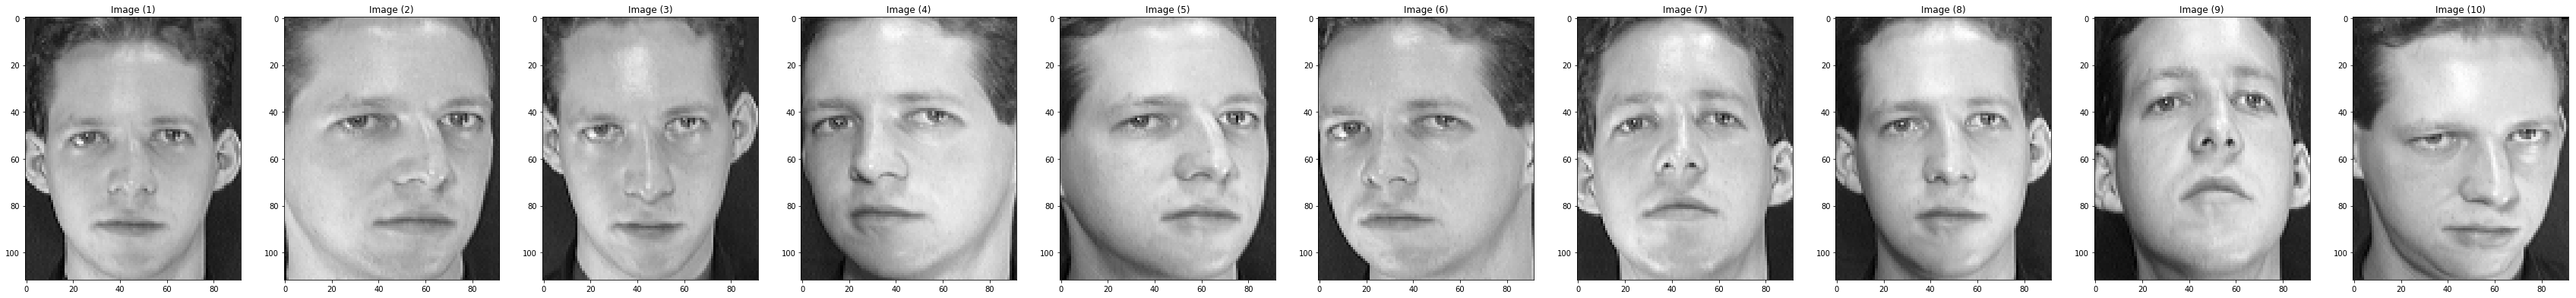

In [11]:
# show 2 persons
show_images(fr.data[1])
show_images(fr.data[2])

## Reduction

There are several methods of dimension reduction, and we will simply choose the one that "looks" better to human eye.
Indeed, the way we reduce the dimension has little importance on the algorithm efficiency.
What matters is only the number of dimensions we choose to keep : the greatest it is, the better the recognition rate.
It has been experimentally shown that, for the face recognition problem, a few hundreds is sufficient.

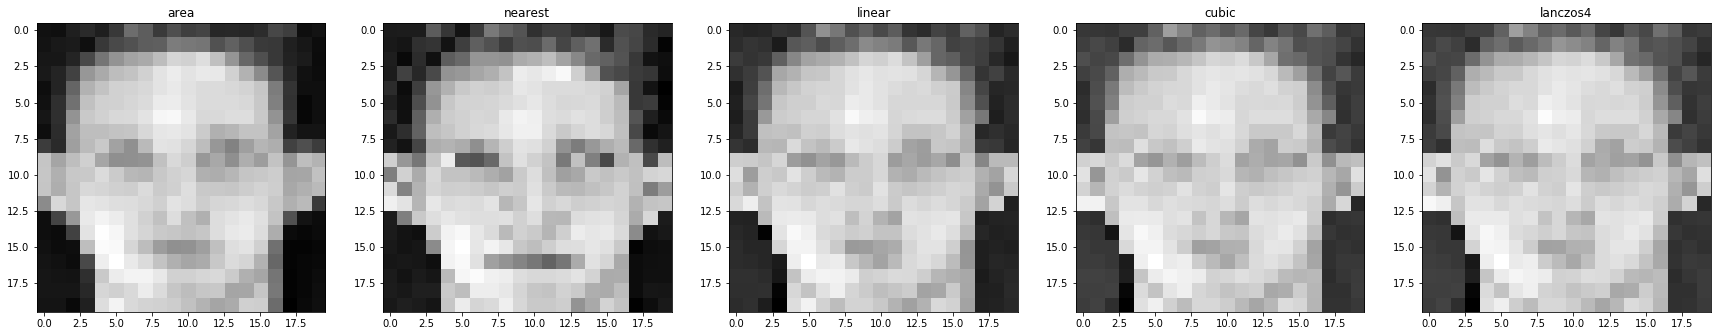

In [92]:
methods=[("area", cv2.INTER_AREA), 
         ("nearest", cv2.INTER_NEAREST), 
         ("linear", cv2.INTER_LINEAR), 
         ("cubic", cv2.INTER_CUBIC), 
         ("lanczos4", cv2.INTER_LANCZOS4)]

img = fr.data[1][0]
images, titles = [], []
for method in methods:
    images.append(cv2.resize(img, reduction_size, interpolation=method[1]))
    titles.append(method[0])
    
show_images(images, cols=1, titles=titles)

## Darkening

Here we use a simple procedure on the pixels to artificially darken the images and then test the face recognition robustness to illumination variations.

In [20]:
def darken_(x, u):
    return max(0, x-u)

darken = np.vectorize(darken_)

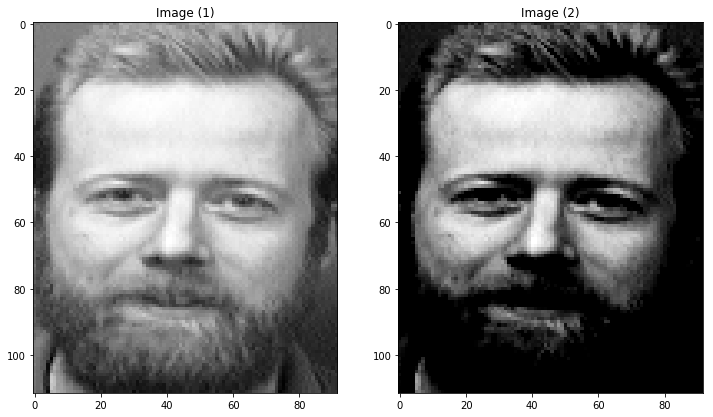

In [21]:
img = np.copy(fr.data[26][0])
show_images([img, darken(img, 100)])

## Occlusion

Here we use a simple procedure on the pixels to artificially occlude the images and then test the face recognition robustness to occlusion.

In [59]:
def occlusion(img):
    img_ = np.copy(img)
    img_[10:15, 10:15] = 0
    return img_

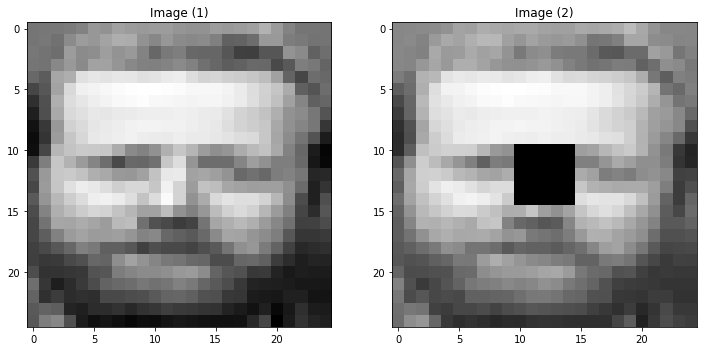

In [60]:
img = np.copy(fr.resized_data[26][0])
show_images([img, occlusion(img)])

# Fast L1 minimisation $y = \Phi c$

The objective is to minimise the the augmented Lagrangian function:
$$
L_\mu(c, \nu) = \|c\|_1 + \langle\nu,y-\Phi c\rangle + \frac{\mu}{2}\|y-\Phi c\|_2^2
$$

For that we will approach the target quantities $(c^*,\nu^*)$ by an iterative algorithm.

The iteration is given by:
$$
c_{k+1} = argmin_c L_{\mu_k}(c, \nu_k)
$$

$$
\nu_{k+1} = \nu_k + \mu_k(y-\Phi c_{k+1})
$$

The first optimisation is done using a FISTA algorithm.

In [8]:
# ALGORITHM

def fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=1000):
    iter_ = 0
    m, n = fr.phi.shape
    c = np.zeros(n)
    v = np.zeros(m)
    de = np.ones(n)
    dc = np.ones(n)
    dc_list = []
    
    while np.linalg.norm(dc) > epsilon and iter_ < iter_max:
        iter_ += 1
        # print('dc: ', np.linalg.norm(dc))
        t = 1
        z = np.ones(n)
        w = np.copy(c)
        dw = np.ones(n)

        # FISTA
        while np.linalg.norm(dw) > epsilon_fista:
            # print('dw: ', np.linalg.norm(dw))
            left = z + np.dot(np.transpose(fr.phi), y - np.dot(fr.phi, z) + v / mu) / gamma
            dw = shrink(left, 1 / (mu * gamma)) - w
            w += dw
            dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
            t += dt
            z = w + (t - dt - 1) / t * dw

        dc = w - c
        dc_list.append(np.linalg.norm(dc))
        c += dc
        v = v + mu * (y - np.dot(fr.phi, c))
        mu += mu_iter
    return c, dc_list

In [71]:
print('eigenvalue max: ', np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi))))

eigenvalue max:  25430.706834753164


In the literature, the gamma parameter used in the FISTA algorithm must be equal to: $$ \gamma = \lambda_{max}\{\Phi^T\Phi\}$$

After several tests, it turns out that the sequence diverges exponentially with such a value. We will therefore choose to arbitrarily increase this parameter to ensure the convergence of the algorithm.

In [106]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 0.1 # 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)

## Monitor the convergence depending on mu constant or increasing

We monitor the convergence of the algorithm in the case without the error $(e_k)$.

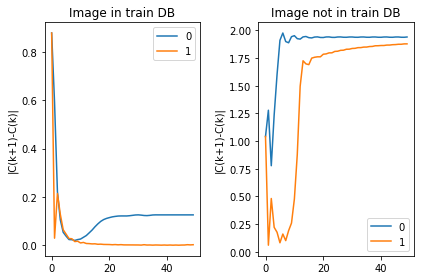

In [74]:
iter_max = 50
mu_iter_list = [0, 1]

# image in train DB
y1 = fr.resized_data[11][0].flatten().astype('float64')
# image not in train DB
y2 = fr.resized_data[11][6].flatten().astype('float64')

deltac = [[], []]
for dc, y in zip(deltac, [y1, y2]):
    for mu_i in mu_iter_list:
        # print(mu_i)
        c, dc_list = fast_l1_minimisation(fr, y, 0., epsilon_fista, gamma, mu, mu_i, iter_max=iter_max)
        dc.append(dc_list)
        
t = np.arange(iter_max)

plt.subplot(1, 2, 1)
plt.plot(t, deltac[0][0], t, deltac[0][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image in train DB')
plt.ylabel('|C(k+1)-C(k)|')

plt.subplot(1, 2, 2)
plt.plot(t, deltac[1][0], t, deltac[1][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image not in train DB')
plt.ylabel('|C(k+1)-C(k)|')
plt.tight_layout()
plt.show()

Those two graphics show the evolution of the variations of $(c_k)$ over the iterations, in blue when $(\mu_k)$ is not incremented, orange when it is.
In most cases, there is no convergence and the variations are the smallest around 10 iterations before they jump.
More precisely, we can see a convergence only when we use a image in the train database. 
We think that, in this model without the error, because of the dimensionnality of matrix $\Phi$ ($m \approx N$) there is no actual solution to the problem (except when when we use a image from the train database $\Phi$).
This problem will not occur anymore in the Cross and Bouquet case.

iter_max := 10

mu_iter := 1

## Find c with the fast l1 minimisation

### First on a face in the train DB

In [107]:
iter_max = 10
mu_iter = 1

true class:  2
class:  2


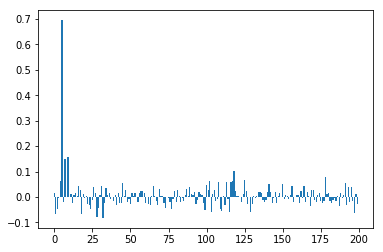

In [108]:
# choose the image to classify
n_person, n_img = (2, 0)
y = fr.resized_data[n_person][n_img].flatten().astype('float64')

c, c_list = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=10)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c'])

print('true class: ', n_person)
print('class: ', fr.which_class(c))
plt.bar(np.arange(c.shape[0]), c)
plt.show()

As we explained, when we run the algorithm on a face which is already in $\Phi$, the algorithm correctly approximate the sparse representation
(One coordinate of $c$ is overwhelming, the one corresponding the y used, the other coordinates looks like noise.)

### Then on a face in the test DB

In [198]:
# choose the image to classify
n_person, n_img = (4, 6)
y = fr.resized_data[n_person][n_img].flatten().astype('float64')

c, c_list = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=10)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c'])

print('true class: ', n_person)
print('class: ', fr.which_class(c))
plt.bar(np.arange(c.shape[0]), c)
plt.show()

true class:  4
class:  4


In this example we see that the algorithm tries to compensate the error with random coordinates and there is no real convergence.
However, the modelisation seems to work : the coordinates of c corresponding to the class 4 are high compared to the others.
Thus, despite the convergence problem, the classification is somehow still efficient if we stop the algorithm after a reasonnable number of iterations.

## Compute the scores

In [62]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)
mu_iter = 1

iter_max = 10

In [19]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = img.flatten().astype('float64')
        c_, dc = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.83


In [22]:
# darkening

c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = darken(img, 30).flatten().astype('float64')
        c_, dc = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.82


In [63]:
# occlusion

c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = occlusion(img).flatten().astype('float64')
        c_, dc = fast_l1_minimisation(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', np.argmax(c_)//5 + 1, ', ', i == np.argmax(c_)//5 + 1)
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.525


# Fast L1 minimisation $y = \Phi c + e$

The new objective is to minimise the the augmented Lagrangian function:
$$
L_\mu(c, e, \nu) = \|c\|_1 + \|e\|_1 + \langle\nu,y-\Phi c-e\rangle + \frac{\mu}{2}\|y-\Phi c-e\|_2^2
$$

For that we will approach the target quantities $(c^*, e^*, \nu^*)$ by an iterative algorithm.

The iteration is given by:

$$
e_{k+1} = argmin_e L_{\mu_k}(c_k, e, \nu_k)
$$

$$
c_{k+1} = argmin_c L_{\mu_k}(c, e_{k+1}, \nu_k)
$$

$$
\nu_{k+1} = \nu_k + \mu_k(y-\Phi c_{k+1} - e_{k+1})
$$

The second optimisation is done using a FISTA algorithm.

In [26]:
# ALGORITHM

def minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=1000):
    m, n = fr.phi.shape
    iter_ = 0

    c = np.zeros(n)
    e = np.copy(y)
    v = np.zeros(m)
    de = np.ones(n)
    dc = np.ones(n)
    dc_list = []
    while np.linalg.norm(dc) > epsilon and iter_ < iter_max:
        iter_ += 1
        
        #print('de: ', np.linalg.norm(de))
        #print('dc: ', np.linalg.norm(dc))
        #print('dpc: ', np.linalg.norm(np.dot(fr.phi, dc)))
        #print('------------------------')

        de = shrink(y - np.dot(fr.phi, c) + v / mu, 1 / mu) - e
        e += de
        t = 1
        z = np.ones(n)
        w = np.copy(c)
        dw = np.ones(n)
        
        #FISTA
        while np.linalg.norm(dw) > epsilon_fista:
            # print('dw: ', np.linalg.norm(dw))
            left = z + np.dot(np.transpose(fr.phi), y - np.dot(fr.phi, z) - e + v / mu) / gamma
            dw = shrink(left, 1 / (mu * gamma)) - w
            w += dw
            dt = (1 + np.sqrt(1 + 4 * t ** 2)) / 2 - t
            t += dt
            z = w + (t - dt - 1) / t * dw

        dc = w - c
        c += dc
        dc_list.append(np.linalg.norm(dc))
        v = v + mu *(y - np.dot(fr.phi, c) - e)
        mu += mu_iter
        
    return c, dc_list, e

In [109]:
# PARAMETERS

epsilon = 0.1
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(fr.resized_data[1][0].flatten().astype('float64'), ord=1)

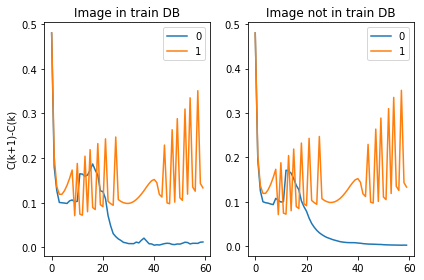

In [11]:
iter_max = 60
mu_iter_list = [0, 1]

# image in train DB
y1 = fr.resized_data[11][0].flatten().astype('float64')
# image not in train DB
y2 = fr.resized_data[11][6].flatten().astype('float64')

deltac = [[], []]
for dc, y in zip(deltac, [y1, y2]):
    for mu_i in mu_iter_list:
        # print(mu_i)
        c, dc_list, e = minimization_with_occlusion(fr, y, 0., epsilon_fista, gamma, mu, mu_i, iter_max=iter_max)
        dc.append(dc_list)
        
t = np.arange(iter_max)

plt.subplot(1, 2, 1)
plt.plot(t, deltac[0][0], t, deltac[0][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image in train DB')
plt.ylabel('C(k+1)-C(k)')

plt.subplot(1, 2, 2)
plt.plot(t, deltac[1][0], t, deltac[1][1])
plt.legend(list(map(str, mu_iter_list)))
plt.title('Image not in train DB')

plt.tight_layout()
plt.show()

We have just tried the Cross and Bouquet model $y = \Phi c + e$. The graphs above show that, for a constant sequence $\mu_k = \mu^*$ of appropriate value found in the litterature $\mu^* = 2m/||y||_1$, the algorithm converges correctly.
We see that, unlike the naive approach $y = \Phi c$, we have convergence on images which are not in $\Phi$.
In the case were $\mu_k$ is an increasing sequence, we think that the issue is that $\mu_k$ is becoming too big too fast :
When $\mu_k$ is getting big, it diminishes the amplitude of the evolution of $c_k$ by iteration. Thus, if $\mu_k$ is increasing faster than $c_k$ is approaching the minimum, there cannot be a convergence.
The other issue was that, if $\mu_k$ is to small, the ALM procedure fails even at a theoretical level. 
The most viable solution was to be able to discover an acceptable threshold $\mu^*$ for $\mu_k$, which we finally did by reviewing the litterature.

In [88]:
# PARAMETERS

epsilon = 0.01
epsilon_fista = 0.001

# gamma = np.max(np.linalg.eigvals(np.dot(np.transpose(fr.phi), fr.phi)))
gamma = 10000000000

mu = 0.1 # 2*reduction_size[0]*reduction_size[1]/np.linalg.norm(y, ord=1)
iter_max = 50
mu_iter = 0

### face in train DB

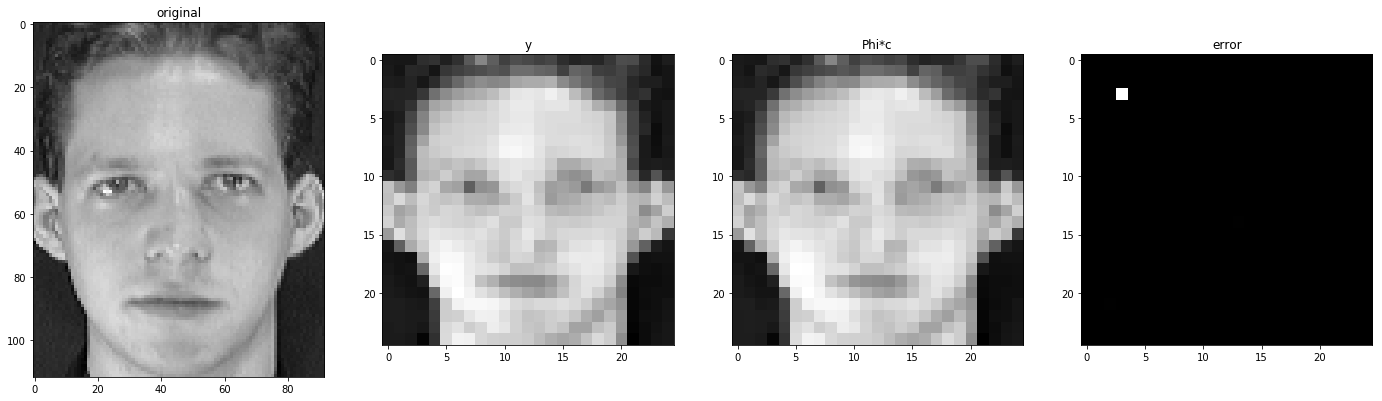

true class:  1
class:  1


In [70]:
# choose the image to classify
n_person, n_img = (1, 0)
y = fr.resized_data[n_person][n_img].flatten().astype('float64')

c, c_list, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)
error = e.astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img, error]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c', 'error'])

print('true class: ', n_person)
print('class: ', np.argmax(c)//5+1)
plt.bar(np.arange(c.shape[0]), c)
plt.title('Combination of the training images')
plt.ylabel('coefficients')
plt.show()

As expected, for a face in $\Phi$, the obtained representation $c$ is 1-sparse and the error $e$ is almost null.

### face not in train DB

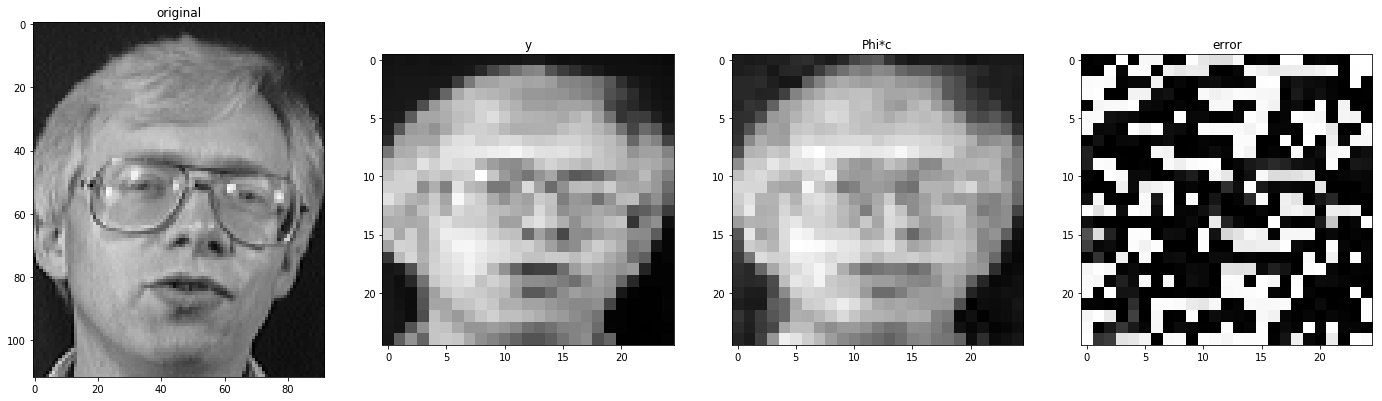

true class:  2
class:  2


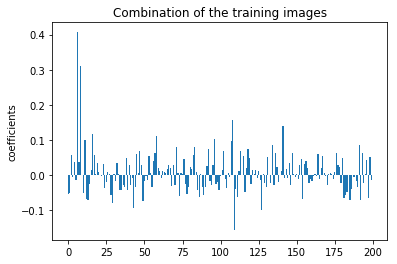

In [104]:
# choose the image to classify
n_person, n_img = (2, 5)
y = np.copy(fr.resized_data[n_person][n_img])
y = y.flatten().astype('float64')


c, c_list, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=200)

img = (np.dot(fr.phi, c)).astype('uint8').reshape(reduction_size)
error = e.astype('uint8').reshape(reduction_size)

images_to_show = [fr.data[n_person][n_img], y.reshape(reduction_size), img, error]
show_images(images_to_show, cols=1, titles=['original', 'y', 'Phi*c', 'error'])

print('true class: ', n_person)
print('class: ', fr.which_class(c))
plt.bar(np.arange(c.shape[0]), c)
plt.title('Combination of the training images')
plt.ylabel('coefficients')
plt.show()

In this case, the sparsity of the obtained representation is less obvious, but the coordinates are all less than half as big as the biggest one.
We can then successfully classify the image by computing the $argmax_i ||c_i||_1$ (with $c_i$ the truncated part of $c$ corresponding to the ith individual).
What is also noteworthy is the sparsity of the error $e$.

## Compute the scores

In [45]:
c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = img.flatten().astype('float64')
        c_, dc, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', fr.which_class(c_), ', ', i == fr.which_class(c_))
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.845


In [55]:
# darkening

c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = darken(img, 30).flatten().astype('float64')
        c_, dc, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', fr.which_class(c_), ', ', i == fr.which_class(c_))
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.85


In [68]:
# occlusion

c_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        y = occlusion(img).flatten().astype('float64')
        c_, dc, e = minimization_with_occlusion(fr, y, epsilon, epsilon_fista, gamma, mu, mu_iter, iter_max=iter_max)
        # print('class: ', fr.which_class(c_), ', ', i == fr.which_class(c_))
        c_list.append(c_)
        
print('score: ', np.mean(np.array([fr.which_class(c_) for c_ in c_list])==np.array(fr.true_class)))

score:  0.665


# Classification with Lasso optimisation 

The objective is perform a lasso regression on the following problem:
$$
argmin_c\|c\|_1 \text{ subject to }\|y-\Phi c\|_2^2 < \epsilon
$$
The new problem is then :
$$
min_c \|y-\Phi c\|_2^2 + \lambda \|c\|_1
$$

In [111]:
def opt_Lasso(fr, img, lbd=1.0, occ=False):
    if occ:
        phi = np.concatenate((fr.phi, np.identity(fr.phi.shape[0])), axis=1)
    else :
        phi = fr.phi
    img = img.flatten()
    lasso = LM.Lasso(alpha=lbd)
    lasso.fit(phi, img)
    return lasso.coef_

#### Residual

For each class $i$, $\delta_i$ is the characteristic function that selects the coefficient associated with the $i^{th}$ class.

The residual is :
$$
r_i(y) = \|y - A\delta_i(c^*)\|
$$
We identify the class of the image by taking the smallest residual among all classes.

In [112]:
def residual(fr, img, xopt, occ=None):
    img = img.flatten() 
    if occ is None:
        occ = 0
    return LA.norm(img - occ - fr.phi.dot(xopt)) 

#### Sparce Concentration index

$$
SCI(x) = \frac{k * max\|\delta_i(x)\|_1/\|x\|_1 - 1}{k-1}
$$
where $k$ is the total number of classes.

For a given solution $c^*$ of the optimization problem, if $SCI(c^*)=0$ the coefficient are spread evenly over all classes and if $SCI(c^*)=1$, the image can be represented using only images from a single individual.

This coefficient allows us to reject images that are not related to any subject in the database.

In [114]:
def SCI(fr, xopt):
    ncl = len(list(fr.data.keys()))
    norms = [LA.norm(fr.class_select(xopt, classe),1) for classe in list(fr.data.keys())]
    return ((ncl * max(norms) / LA.norm(xopt,1) - 1) / (ncl - 1))

### Classification

In [115]:
def SRC(fr, img, tau=0.3, lbd=100, occ=False):
    xopt = opt_Lasso(fr, img, lbd, occ=occ)
    if occ :
        err = xopt[:fr.phi.shape[0]]
        xopt = xopt[fr.phi.shape[0]:]
    else:
        err = None
    sci = SCI(fr, xopt)
    if sci > tau:
        residuals = {classe: residual(fr, img, fr.class_select(xopt, classe), occ=err) for classe in list(fr.data.keys())}
        img_reco = (np.dot(fr.phi, xopt)).astype('uint8').reshape((25, 25))
        return min(residuals, key=residuals.get)
    else:
        return None 

### face in train DB

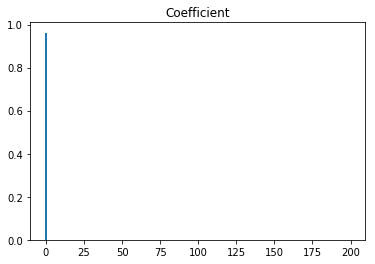

SCI 1.0


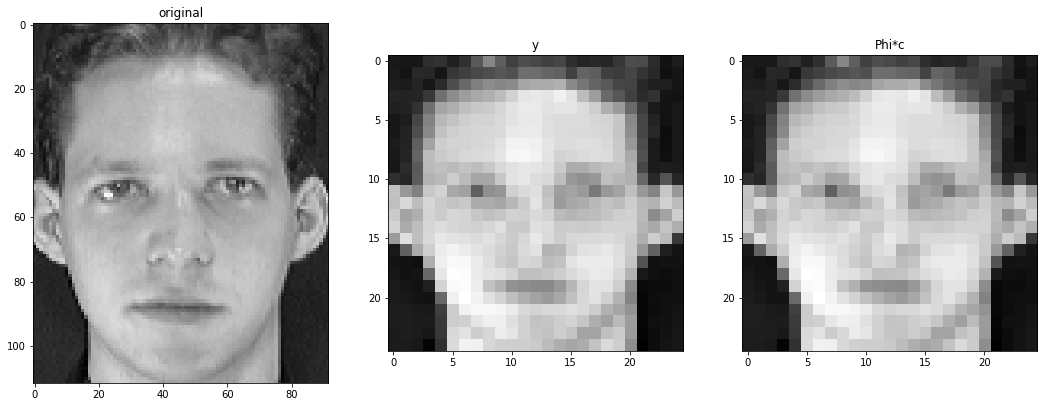

In [125]:
n_person, n_img = (1, 0)
c = opt_Lasso(fr, fr.resized_data[n_person][n_img].flatten().astype('float64'),lbd=100)
img2 = (np.dot(fr.phi, c)).astype('uint8').reshape((25, 25))


# Représentation des coefficients 
plt.bar(np.arange(len(c)),np.round(c,3))
plt.title('Coefficient')
plt.show()

# Residuals
residuals = {classe: residual(fr, img2, fr.class_select(c, classe)) for classe in list(fr.data.keys())}
plt.bar(np.arange(len(residuals)), list(residuals.values()))
plt.title('Residuals')
plt.show()

# SCI
print('SCI', SCI(fr, c))

#SHOW 
show_images([fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img2], cols=1, titles=['original', 'y', 'Phi*c'])

As expected for a face in $\Phi$, the coefficients are extremely sparse and the residuals allow us to clearly identify the class. Moreover the SCI is equal to 1 which shows that the algorithm perfectly identified the subject. 

### Face not int train DB

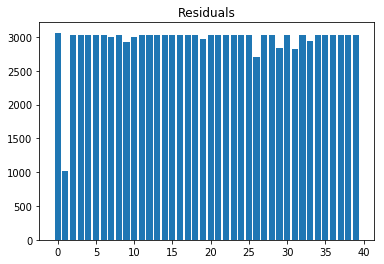

SCI 0.6292677149855


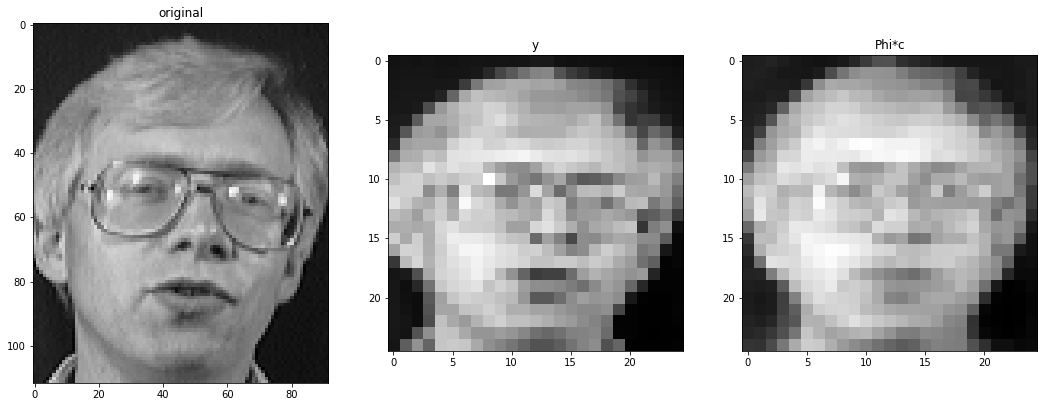

In [127]:
n_person, n_img = (2, 5)
c = opt_Lasso(fr, fr.resized_data[n_person][n_img].flatten().astype('float64'),lbd=100)
img2 = (np.dot(fr.phi, c)).astype('uint8').reshape((25, 25))


# Représentation des coefficients 
plt.bar(np.arange(len(c)),np.round(c,3))
plt.title('Coefficient')
plt.show()

# Residuals
residuals = {classe: residual(fr, img2, fr.class_select(c, classe)) for classe in list(fr.data.keys())}
plt.bar(np.arange(len(residuals)), list(residuals.values()))
plt.title('Residuals')
plt.show()

# SCI
print('SCI', SCI(fr, c))

#SHOW 
show_images([fr.data[n_person][n_img], fr.resized_data[n_person][n_img], img2], cols=1, titles=['original', 'y', 'Phi*c'])

The coefficients are not as sparse as they were for the face from the database but one class is still much more represented than the other. This is consistant with the residuals : even if the difference is less important than in the first case, the difference between the smallest one and the others is large enough to identify precisely the subject. This is confirmed by the value of the SCI.

## Select lambda

In [129]:
lambdas = np.array([10, 100, 300, 500, 700, 800, 900, 950])
scores = list()
for lbd in lambdas:
    c_list = list()
    true_classes = []
    for i, l in fr.resized_data.items():
        for img in l[len(l)//2:]:
            true_classes.append(i)
            c_ = SRC(fr,darken(img, 30).flatten().astype('float64'), tau=0.001, lbd=lbd)
            if c_ is not None:
                c_list.append(c_)
            else:
                c_list.append('None')
    print(lbd, 'score', np.mean(np.array(c_list)==np.array(true_classes)))
    scores.append(np.mean(np.array(c_list)==np.array(true_classes)))
    
# plot 
plt.plot(lambdas, scores, '-.')
plt.show()

/Users/Nicolas/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 score 0.9
100 score 0.925
300 score 0.915
500 score 0.85
700 score 0.755
800 score 0.735
900 score 0.685


/Users/Nicolas/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


950 score 0.0


/Users/Nicolas/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/Nicolas/.virtualenvs/facecourse-py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


In [130]:
lbd = 100

## Compute the scores

In [132]:
c_list = list()
true_classes = []
for i, l in fr.resized_data.items():
    for img in l[len(l)//2:len(l)//2+5]:
        true_classes.append(i)
        c_ = SRC(fr, img.flatten().astype('float64'), tau=0.001, lbd=lbd)
        if c_ is not None:
            c_list.append(c_)
        else:
            c_list.append('None')
print('score', np.mean(np.array(c_list)==np.array(true_classes)))

score 0.925


In [133]:
# Darkening 

c_list = list()
true_classes = []
for i, l in fr.resized_data.items():
    for img in l[len(l)//2:len(l)//2+5]:
        true_classes.append(i)
        c_ = SRC(fr, darken(img, 30).flatten().astype('float64'), tau=0.001, lbd=lbd)
        if c_ is not None:
            c_list.append(c_)
        else:
            c_list.append('None')
print('score', np.mean(np.array(c_list)==np.array(true_classes)))

score 0.925


In [134]:
# Occlusion 

c_list = list()
true_classes = []
for i, l in fr.resized_data.items():
    for img in l[len(l)//2:]:
        true_classes.append(i)
        c_ = SRC(fr, occlusion(img).flatten().astype('float64'), tau=0.001, lbd=lbd)
        if c_ is not None:
            c_list.append(c_)
        else:
            c_list.append('None')
print('score', np.mean(np.array(c_list)==np.array(true_classes)))

score 0.855


# Benchmark with kNN

In [23]:
def knn_classifier(fr, n_neighbors=3):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(np.transpose(fr.phi), fr.true_class)
    return neigh

In [24]:
knn = knn_classifier(fr, 1)
class_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        cls = knn.predict([img.flatten().astype('float64')])[0]
#        print('class: ', c_)
        class_list.append(cls)
        
print('score: ', np.mean(np.array(class_list)==np.array(fr.true_class)))

score:  0.905


In [25]:
# darkening

knn = knn_classifier(fr, 1)
class_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        cls = knn.predict([darken(img, 30).flatten().astype('float64')])[0]
#        print('class: ', c_)
        class_list.append(cls)

print('score: ', np.mean(np.array(class_list)==np.array(fr.true_class)))

score:  0.53


In [64]:
# occlusion

knn = knn_classifier(fr, 1)
class_list = list()
for i, l in fr.resized_data.items():
    for img in l[5:]:
        cls = knn.predict([occlusion(img).flatten().astype('float64')])[0]
#        print('class: ', c_)
        class_list.append(cls)

print('score: ', np.mean(np.array(class_list)==np.array(fr.true_class)))

score:  0.875


# Results

| Scores | Original |  Darken  | Occlusion |
|:------:|:--------:|:--------:|:----------:
|  kNN   |   90.5   |    53    |    87.5   |
|ALM w/o e|    83    |    82    |    52.5   |
|  ALM   |   84.5   |    85    |    66.5   |
|  lasso   |   92.5   |    92.5    |    85.5   |

The kNN scores are quite high compared to the algorithm ALM because the photos have all been taken under the same conditions. Thus, the distances between the images give in this case a good classifier. The occlusion performed only slightly changes in the order of the distances between the images, the score in this case remains good.  However, it is observed that the kNN no longer works for darken images. ALM algorithms are more robust for these types of disturbances.